In [2]:
import re
import glob
import pandas as pd
import nibabel as nb
import numpy as np
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting

/data/softwares/anaconda3/2019.10/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# importing rmaps

In [179]:
network_interest = "DMN"
connectivity_maps = glob.glob("rest/rmap_seeds/*sub*_"+network_interest+".nii.gz")
len(connectivity_maps)

112

In [180]:
#load the csv files
cimaq_diagnostic = pd.read_csv('cimaq_inference_p02_hpspaper_27012020.csv')
cimaq_diagnostic.rename(columns = {"Unnamed: 0":"subID"},inplace=True)

#print(set(cimaq_diagnostic['36448_diagnostic_clinique'].values))
print(cimaq_diagnostic.columns)


Index(['subID', 'Low_risk', 'Moderate_risk', 'High_risk', 'vbm_qc'], dtype='object')


In [181]:
cimaq_diagnostic["moderate_high_risk"]= ""
for i,r in cimaq_diagnostic.iterrows():
    cimaq_diagnostic.loc[i,"moderate_high_risk"] = cimaq_diagnostic.loc[i,"High_risk"] + cimaq_diagnostic.loc[i,"Moderate_risk"]

In [182]:
#Get the subject IDs from the the rmaps
subjectID_set = set(["sub"+sub.split("sub")[1].split("_")[0] for sub in connectivity_maps])
subjectID_set

{'sub108391',
 'sub120839',
 'sub122922',
 'sub127228',
 'sub139593',
 'sub150649',
 'sub164965',
 'sub175295',
 'sub195287',
 'sub197192',
 'sub199801',
 'sub219637',
 'sub229301',
 'sub247659',
 'sub254402',
 'sub254530',
 'sub255499',
 'sub258618',
 'sub258912',
 'sub267168',
 'sub270218',
 'sub271596',
 'sub288654',
 'sub314409',
 'sub318809',
 'sub324734',
 'sub326073',
 'sub336665',
 'sub337021',
 'sub350555',
 'sub370092',
 'sub373285',
 'sub385370',
 'sub388174',
 'sub396250',
 'sub401205',
 'sub402979',
 'sub403131',
 'sub413474',
 'sub421163',
 'sub427357',
 'sub430653',
 'sub437101',
 'sub439776',
 'sub441008',
 'sub444580',
 'sub458807',
 'sub459801',
 'sub462345',
 'sub463105',
 'sub467954',
 'sub484204',
 'sub490035',
 'sub502616',
 'sub517070',
 'sub520377',
 'sub543589',
 'sub548404',
 'sub549994',
 'sub560180',
 'sub562245',
 'sub567214',
 'sub584267',
 'sub587006',
 'sub597569',
 'sub628299',
 'sub628513',
 'sub637798',
 'sub640283',
 'sub651050',
 'sub652850',
 'sub6

In [183]:
#drop the subjects from csv if rmaps are not present
cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["subID"].isin(subjectID_set)]
cimaq_diagnostic["subID"]

0      sub108391
1      sub120839
2      sub122922
3      sub127228
4      sub139593
         ...    
122    sub974246
123    sub983291
124    sub988602
125    sub996599
126    sub998166
Name: subID, Length: 95, dtype: object

In [184]:
cimaq_diagnostic

,subID,Low_risk,Moderate_risk,High_risk,vbm_qc,moderate_high_risk
0,sub108391,1,0,0,1,0
1,sub120839,1,0,0,1,0
2,sub122922,1,0,0,1,0
3,sub127228,0,0,1,1,1
4,sub139593,0,1,0,1,1
...,...,...,...,...,...,...
122,sub974246,1,0,0,1,0
123,sub983291,1,0,0,1,0
124,sub988602,1,0,0,1,0
125,sub996599,1,0,0,1,0


In [185]:
print(cimaq_diagnostic.shape)
cimaq_diagnostic

(95, 6)


,subID,Low_risk,Moderate_risk,High_risk,vbm_qc,moderate_high_risk
0,sub108391,1,0,0,1,0
1,sub120839,1,0,0,1,0
2,sub122922,1,0,0,1,0
3,sub127228,0,0,1,1,1
4,sub139593,0,1,0,1,1
...,...,...,...,...,...,...
122,sub974246,1,0,0,1,0
123,sub983291,1,0,0,1,0
124,sub988602,1,0,0,1,0
125,sub996599,1,0,0,1,0


# import csv file 

In [186]:
print(cimaq_diagnostic.shape)
cimaq_diagnostic.head()

(95, 6)


,subID,Low_risk,Moderate_risk,High_risk,vbm_qc,moderate_high_risk
0,sub108391,1,0,0,1,0
1,sub120839,1,0,0,1,0
2,sub122922,1,0,0,1,0
3,sub127228,0,0,1,1,1
4,sub139593,0,1,0,1,1


In [187]:
design_matrix = cimaq_diagnostic[["Low_risk","moderate_high_risk"]]
design_matrix
print(np.sum(cimaq_diagnostic["moderate_high_risk"].values))
print(np.sum(cimaq_diagnostic["Low_risk"].values))
print(np.sum(cimaq_diagnostic["High_risk"].values))
print(np.sum(cimaq_diagnostic["Moderate_risk"].values))

31
64
8
23


# create design matrix

In [188]:

# cimaq_diagnostic["MCI"] = 0
# cimaq_diagnostic["SCD"] = 0
# cimaq_diagnostic["CN"] = 0

# for i,r in cimaq_diagnostic.iterrows():
    
#     #print(i)
#     if(r["diagnostic"] == "troubles_subjectifs_de_cognition" ):
#         cimaq_diagnostic.loc[i,"SCD"] = 1

#     if(r["diagnostic"] == "cognitivement_sain_(cs)"):
#         cimaq_diagnostic.loc[i,"CN"] = 1          

#     if("trouble_cognitif_léger" in r["diagnostic"] ):
#         cimaq_diagnostic.loc[i,"MCI"] = 1


#     cimaq_diagnostic.loc[i,"subID"] = str(r["subID"]).split(".")[0]
    

# # cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] != "démence_de_type_alzheimer-légère" ]
# # cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["subID"].isin(subjectID_set)]
# cimaq_diagnostic.head()

In [189]:
#design_matrix = cimaq_diagnostic[["MCI","SCD","CN"]]
#design_matrix.shape

# perform  t-test

In [190]:
#take the rmaps that are in the csv
second_level_input = []
for i in connectivity_maps:
    sub = re.search("\w\w\w\d\d\d\d\d\d",i)
    subid = sub.group(0)
    if(subid in set(cimaq_diagnostic["subID"].values)):        
        second_level_input.append(i)
second_level_input

['rest/rmap_seeds/rmap_sub427357_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub920577_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub562245_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub932933_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub936730_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub271596_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub401205_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub373285_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub893978_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub652850_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub199801_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub270218_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub254530_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub175295_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub988602_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub385370_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub122922_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub258618_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub462345_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub490035_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub430653_DMN.nii.gz',
 'rest/rmap_seeds/rmap_sub956049_D

In [191]:
second_level_model = SecondLevelModel().fit(second_level_input, design_matrix=design_matrix)
z_score = second_level_model.compute_contrast(second_level_contrast = [-1,1])

/home/hanads/.local/lib/python3.7/site-packages/nilearn/plotting/html_stat_map.py:83: UserWarning: Threshold given was 1e-06, but the data has no values below -3.842716693878174. 
  data.min()))
/home/hanads/.local/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



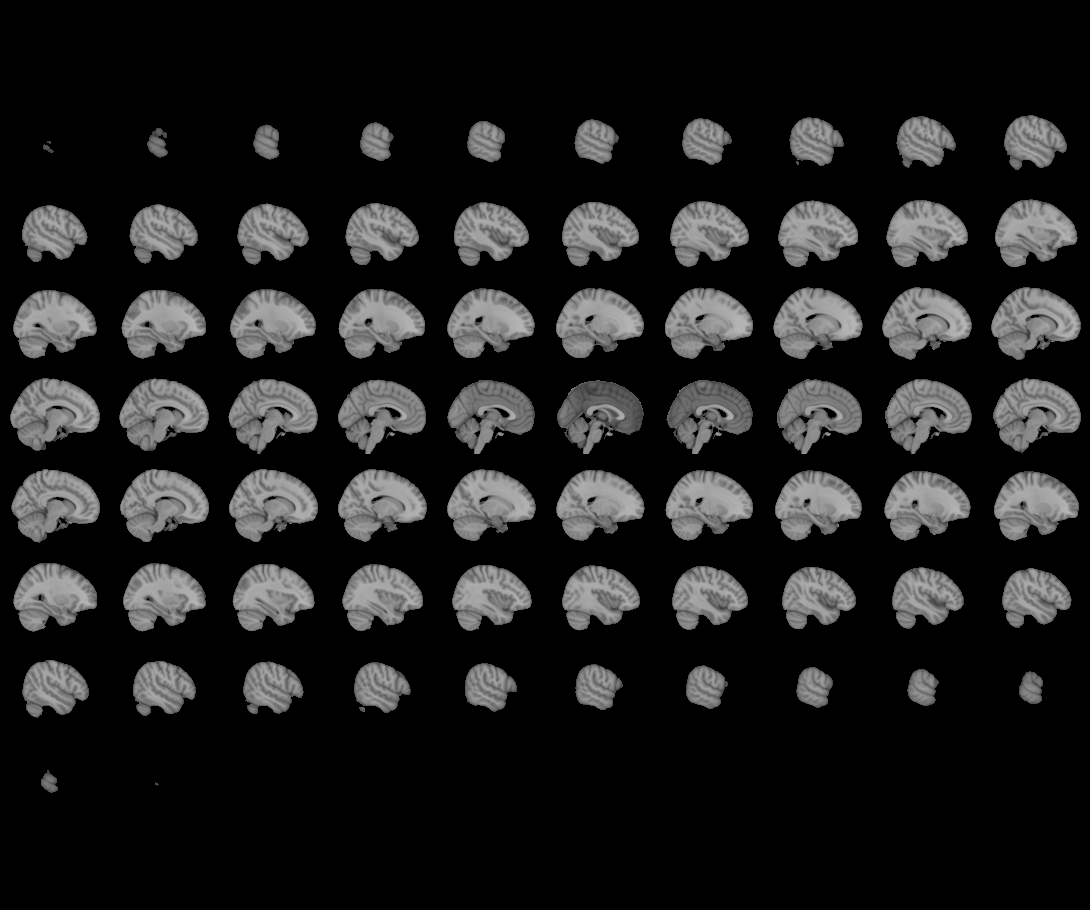
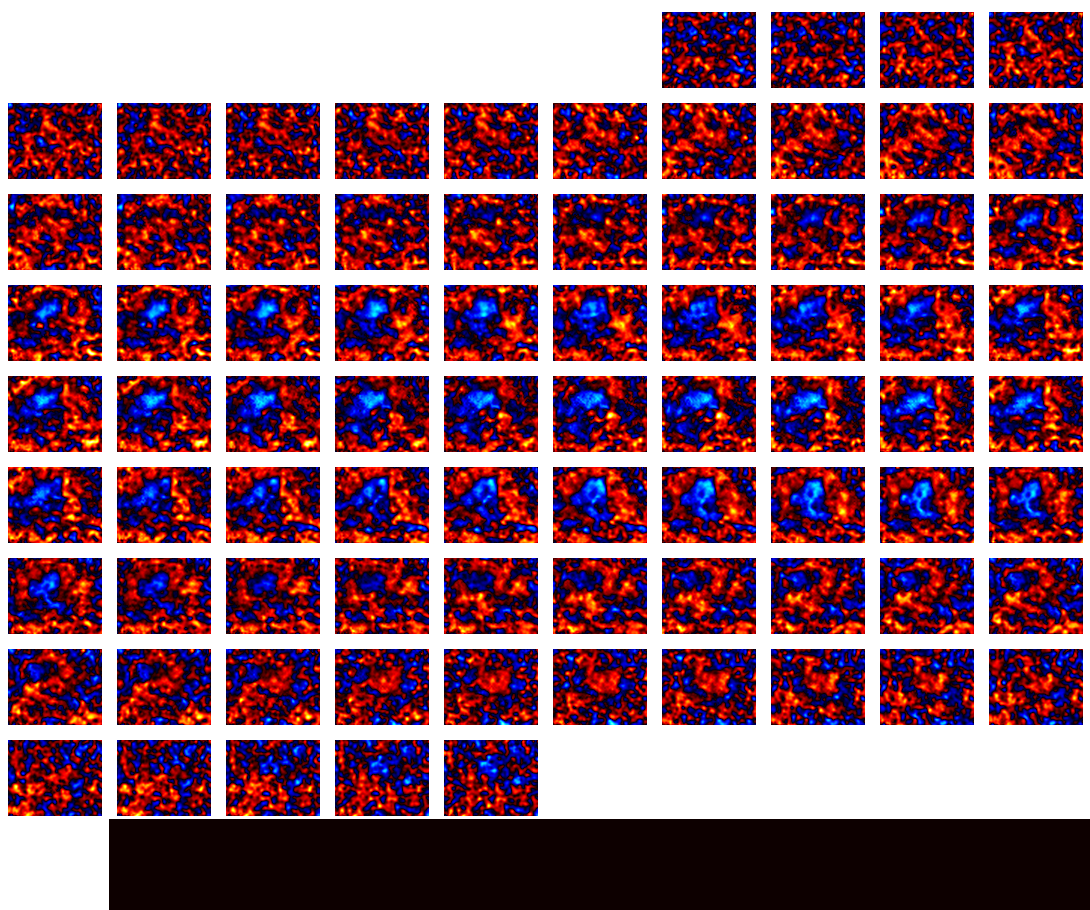

In [192]:
plotting.view_img(z_score)

/home/hanads/.local/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



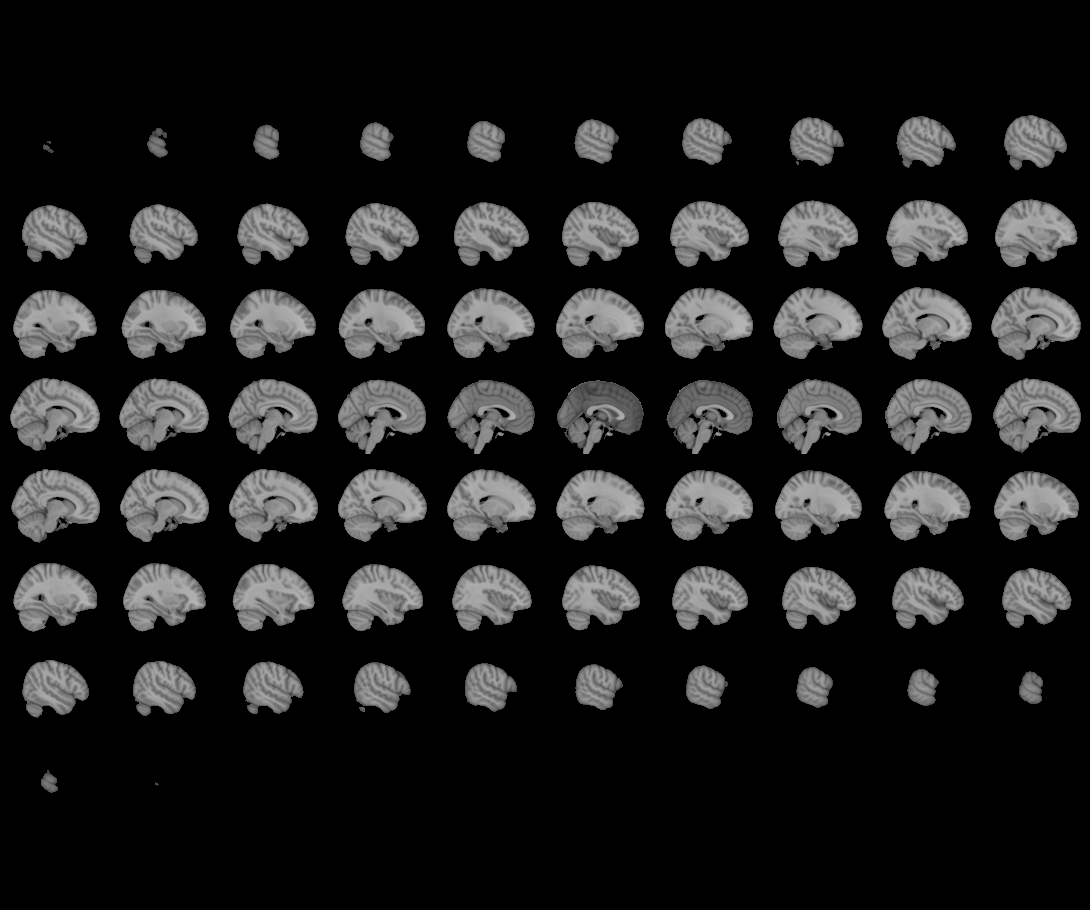
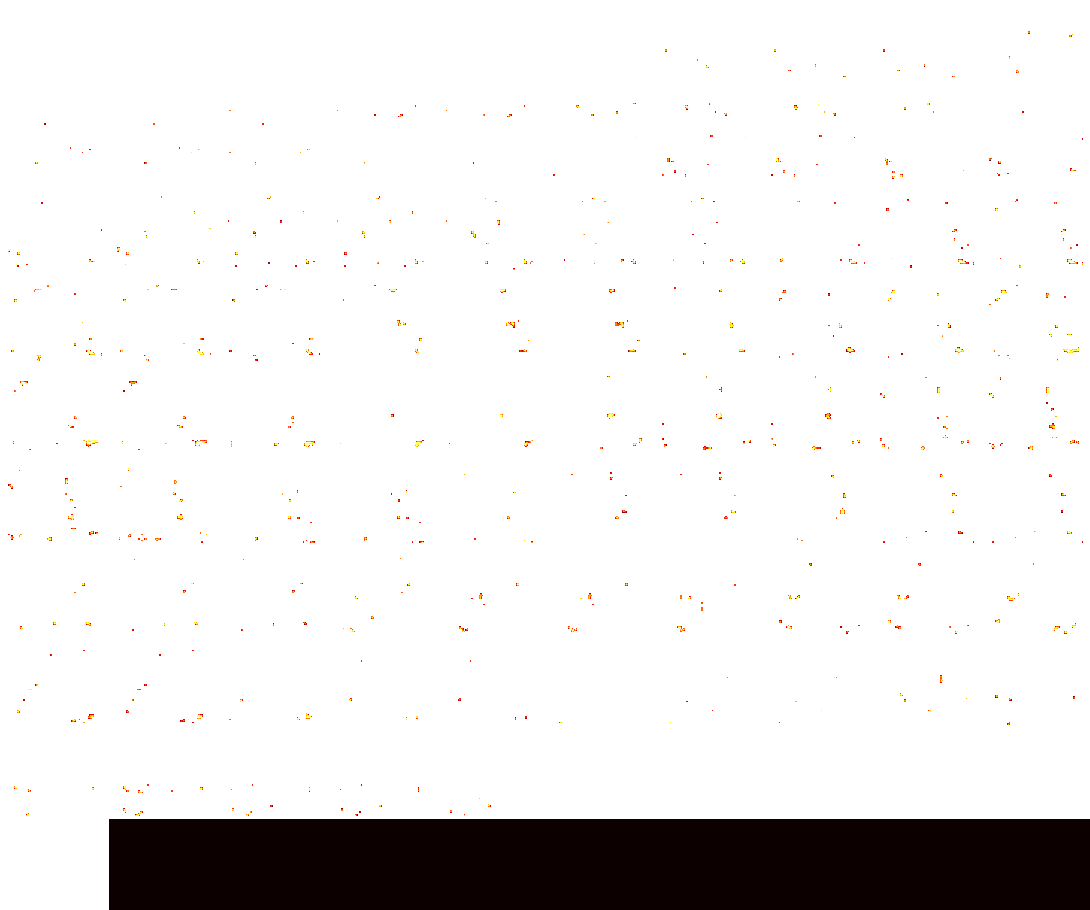

In [200]:
thresholded_map, threshold = map_threshold(z_score, alpha=0.3, height_control='fdr')
plotting.view_img(thresholded_map)

# F-test

In [194]:
second_level_model2 = SecondLevelModel().fit(second_level_input, design_matrix=design_matrix)
p_map = second_level_model2.compute_contrast(second_level_contrast = [1,1,1], second_level_stat_type = "F")

ValueError: shapes (3,) and (2,176384) not aligned: 3 (dim 0) != 2 (dim 0)

In [ ]:
plotting.view_img(p_map)